In [1]:
from nipype.algorithms.metrics import FuzzyOverlap
from nilearn.image import resample_to_img
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
from nilearn import plotting
import nibabel as nib
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import json
import sys
import os

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils import get_config, atlas
from utils.prog import log_progress as lp

%matplotlib inline

sns.set_style('white')

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

sns.set_palette(palettable.tableau.ColorBlind_10.mpl_colors)

/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pipelines= ['fmriprep-1.0.3','fslfeat_5.0.9']

In [3]:
basedir = os.path.join(os.environ.get("PREPBASEDIR"),"fmriprep_vs_feat")

# Example: 1 (random) group analysis

In [4]:
samplesize = 50
experiment = np.random.choice(range(200,400))
sample = 0
im = 'OLS/stats/tstat1.nii.gz'

tstatfile = {}
pstatfile = {}
tstat = {}

for pipeline in pipelines:
    tfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                         'sample_%i/cope11/%s'%(sample,im))
    tstatfile[pipeline]=tfile
    pfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                         'sample_%i/cope11/OLS/stats/pstat1.nii.gz'%sample)
    pstatfile[pipeline]=pfile
    tstat[pipeline]=nib.load(tfile).get_data()


### T distributions of example group study

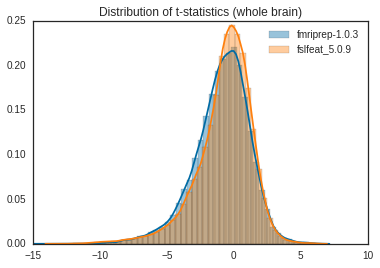

In [5]:
for pipeline in pipelines:
    ts = tstat[pipeline]
    sns.distplot(ts[ts!=0],label=pipeline)

plt.title("Distribution of t-statistics (whole brain)")
plt.legend()

/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


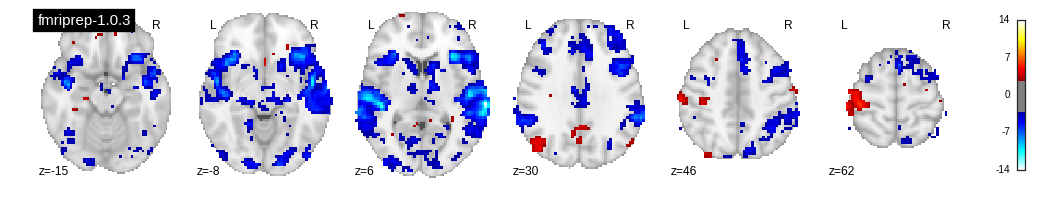

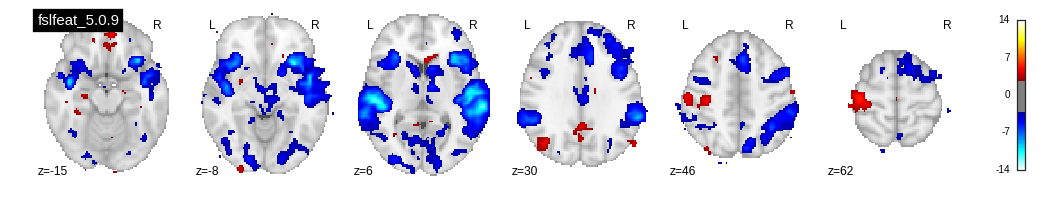

In [6]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    plotting.plot_stat_map(ts,title=pipeline,threshold=2.98,display_mode='z',cut_coords=cut_coords,vmax=14)
plotting.show()

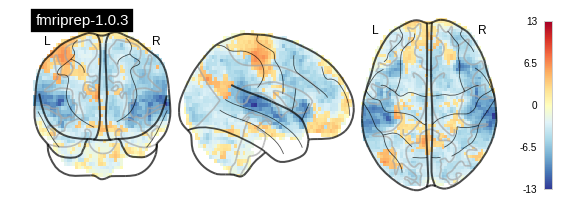

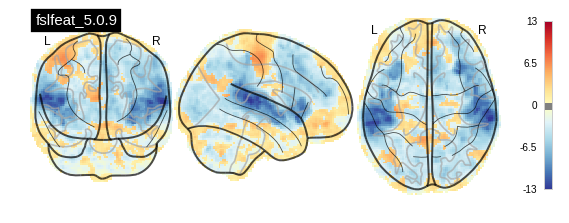

In [26]:
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    plotting.plot_glass_brain(ts,title=pipeline,cmap='RdYlBu_r',
                              vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

# Atlases and effect sizes in regions

In [8]:
atlas,labels = atlas.create_atlas()

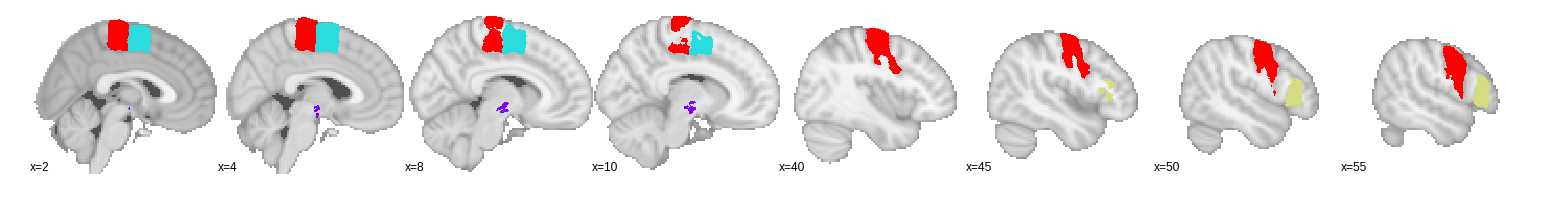

In [9]:
cut_coords = [2,4,8,10,40,45,50,55]
plotting.plot_roi(atlas,display_mode='x',cut_coords=cut_coords,cmap='rainbow',alpha=1)

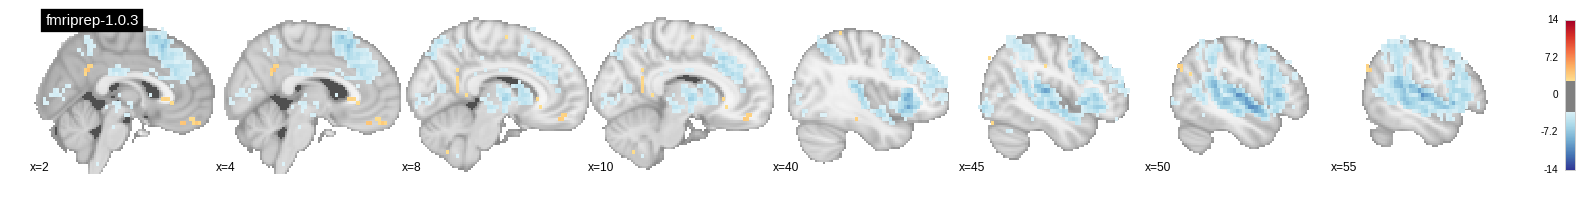

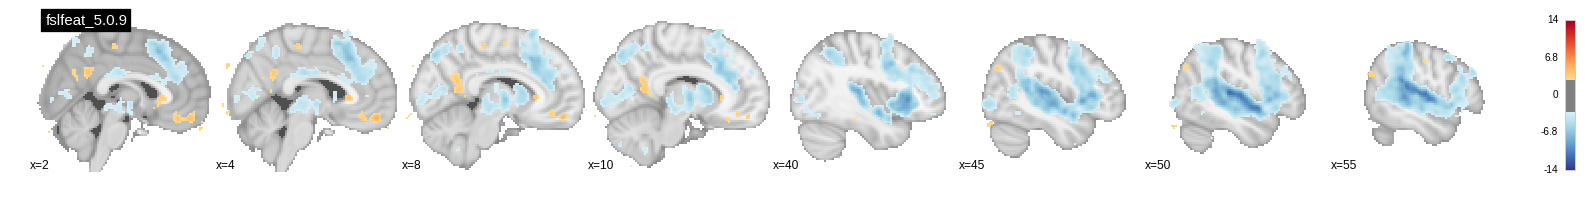

In [35]:
cut_coords = [2,4,8,10,40,45,50,55]
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    plotting.plot_stat_map(ts,display_mode='x',cut_coords=cut_coords,cmap='RdYlBu_r',
                       alpha=1,threshold=2.98,title=pipeline)

In [10]:
ES = {}
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    atlas_resampled = resample_to_img(atlas,ts,interpolation='nearest')
    dat = atlas_resampled.get_data()
    ES[pipeline] = {}
    for k,v in labels.iteritems():
        indxs = np.where(dat==k)
        T = nib.load(tfile).get_data()[indxs]
        CD = np.mean(T)/np.sqrt(samplesize)
        ES[pipeline][v] = CD

In [11]:
pd.DataFrame(ES)

,fmriprep-1.0.3,fslfeat_5.0.9
IFG,0.014912,-0.227046
PCG,-0.055837,0.038679
STN,-0.132380,-0.342115
preSMA,0.043811,0.021667


# Test-retest replicability for different sample sizes

In [12]:
results = pd.read_csv(os.path.join(basedir,"results.csv"),index_col=0)

with open(os.path.join(basedir,"tvals.json")) as json_data:
    allT = json.load(json_data)
    json_data.close()

In [13]:
results.head()

,IFG,PCG,STN,correlation,dice,experiment,fdice,pipeline,preSMA,samplesize
0,-0.178780,0.047879,-0.347886,0.406963,NaN,1,0.936810,fmriprep-1.0.3,0.187530,10
1,-0.018633,-0.008061,-0.307840,0.420029,NaN,2,0.938833,fmriprep-1.0.3,0.067271,10
2,-0.319850,-0.140962,-0.478731,0.507892,NaN,3,0.941225,fmriprep-1.0.3,-0.420609,10
3,0.084494,0.040409,-0.327683,0.368946,NaN,4,0.937903,fmriprep-1.0.3,0.065498,10
4,-0.512003,-0.153870,-0.095368,0.444201,NaN,5,0.944980,fmriprep-1.0.3,-0.169115,10


In [14]:
Counter(results.samplesize)

Counter({10.0: 198,
         15.0: 200,
         20.0: 200,
         25.0: 200,
         30.0: 200,
         35.0: 200,
         40.0: 200,
         45.0: 200,
         50.0: 200,
         55.0: 200,
         60.0: 200,
         65.0: 198,
         70.0: 198,
         75.0: 198,
         80.0: 198,
         85.0: 198,
         90.0: 198,
         95.0: 198,
         100.0: 198})

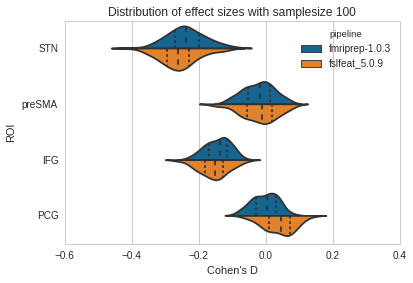

In [15]:
samplesize = 60
reslong = pd.melt(results,id_vars=['pipeline','samplesize'],
                  value_vars=labels.values(),var_name="ROI",value_name="Cohen's D")

def ESfigure(reslong,samplesize):
    sns.set_style("whitegrid")
    sns.violinplot(x="Cohen's D",y='ROI',hue='pipeline',data=reslong[reslong.samplesize==samplesize],
                   split=True,inner='quartile')
    plt.title("Distribution of effect sizes with samplesize %i"%samplesize)
    plt.xlim([-0.6,0.4])

ESfigure(reslong,100)

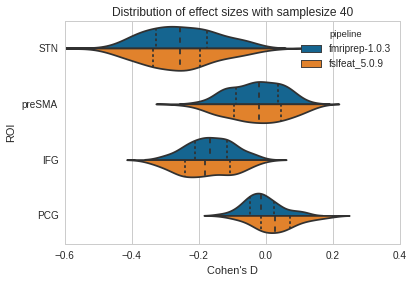

In [16]:
ESfigure(reslong,40)

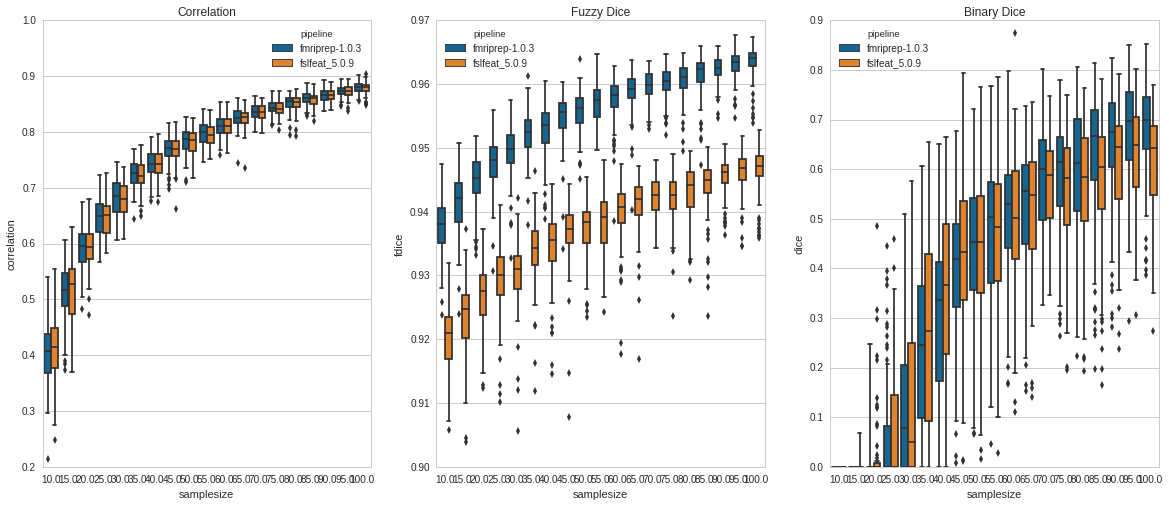

In [17]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(x="samplesize", y="correlation", hue="pipeline", data=results)
plt.title("Correlation")
plt.subplot(1,3,2)
sns.boxplot(x="samplesize", y="fdice", hue="pipeline", data=results)
plt.title("Fuzzy Dice")
plt.subplot(1,3,3)
sns.boxplot(x="samplesize", y="dice", hue="pipeline", data=results)
plt.title("Binary Dice")

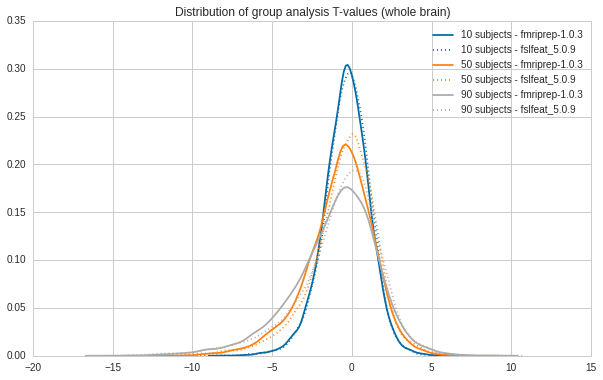

In [18]:
fig = plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')

for idx,samplesize in enumerate(np.arange(10,101,40).tolist()):
    for idy,pipeline in enumerate(pipelines):
        if idy==0:
            lsty = '-'
        else:
            lsty = ':'
        sns.distplot(allT[pipeline][str(samplesize)],color=cols[idx],hist=False,
                     kde_kws={"linestyle": lsty},label="%i subjects - %s"%(samplesize,pipeline))

plt.title("Distribution of group analysis T-values (whole brain)")
plt.legend()